---------- point1 1635 ----------
16.33333513431742 22.50288686552058 90.36790571857749
17.277840643616884 32.52664219194115 463.71777145818623
76.9 %の確率で極値増加
14.712475788395153 19.480806919332792 97.67008824658923
13.731568200072562 17.497694091327645 55.90144603862883
33.4 %の確率で極値増加
---------- point2 1650 ----------
19.160597226099405 24.209465895025197 85.06477495014558
17.450057897490726 22.26363615601433 100.22989528640854
42.9 %の確率で極値増加
15.59575052238555 17.01487491009556 28.851287872693057
15.919497137185157 19.210339170736926 45.06075417365348
77.1 %の確率で極値増加
---------- point3 2726 ----------
15.8365648099633 18.503995519433147 59.66676893143192
20.326154539881593 29.55816567726761 144.7389263658807
88.6 %の確率で極値増加
15.040315152600261 25.886922314958596 230.04008885223044
16.69168139557909 33.59831640975621 724.1217390742814
66.9 %の確率で極値増加
---------- point4 3378 ----------
19.656922371846978 29.83097494987133 313.36852522108467
17.276768393472047 24.413898517325077 135.04030516504

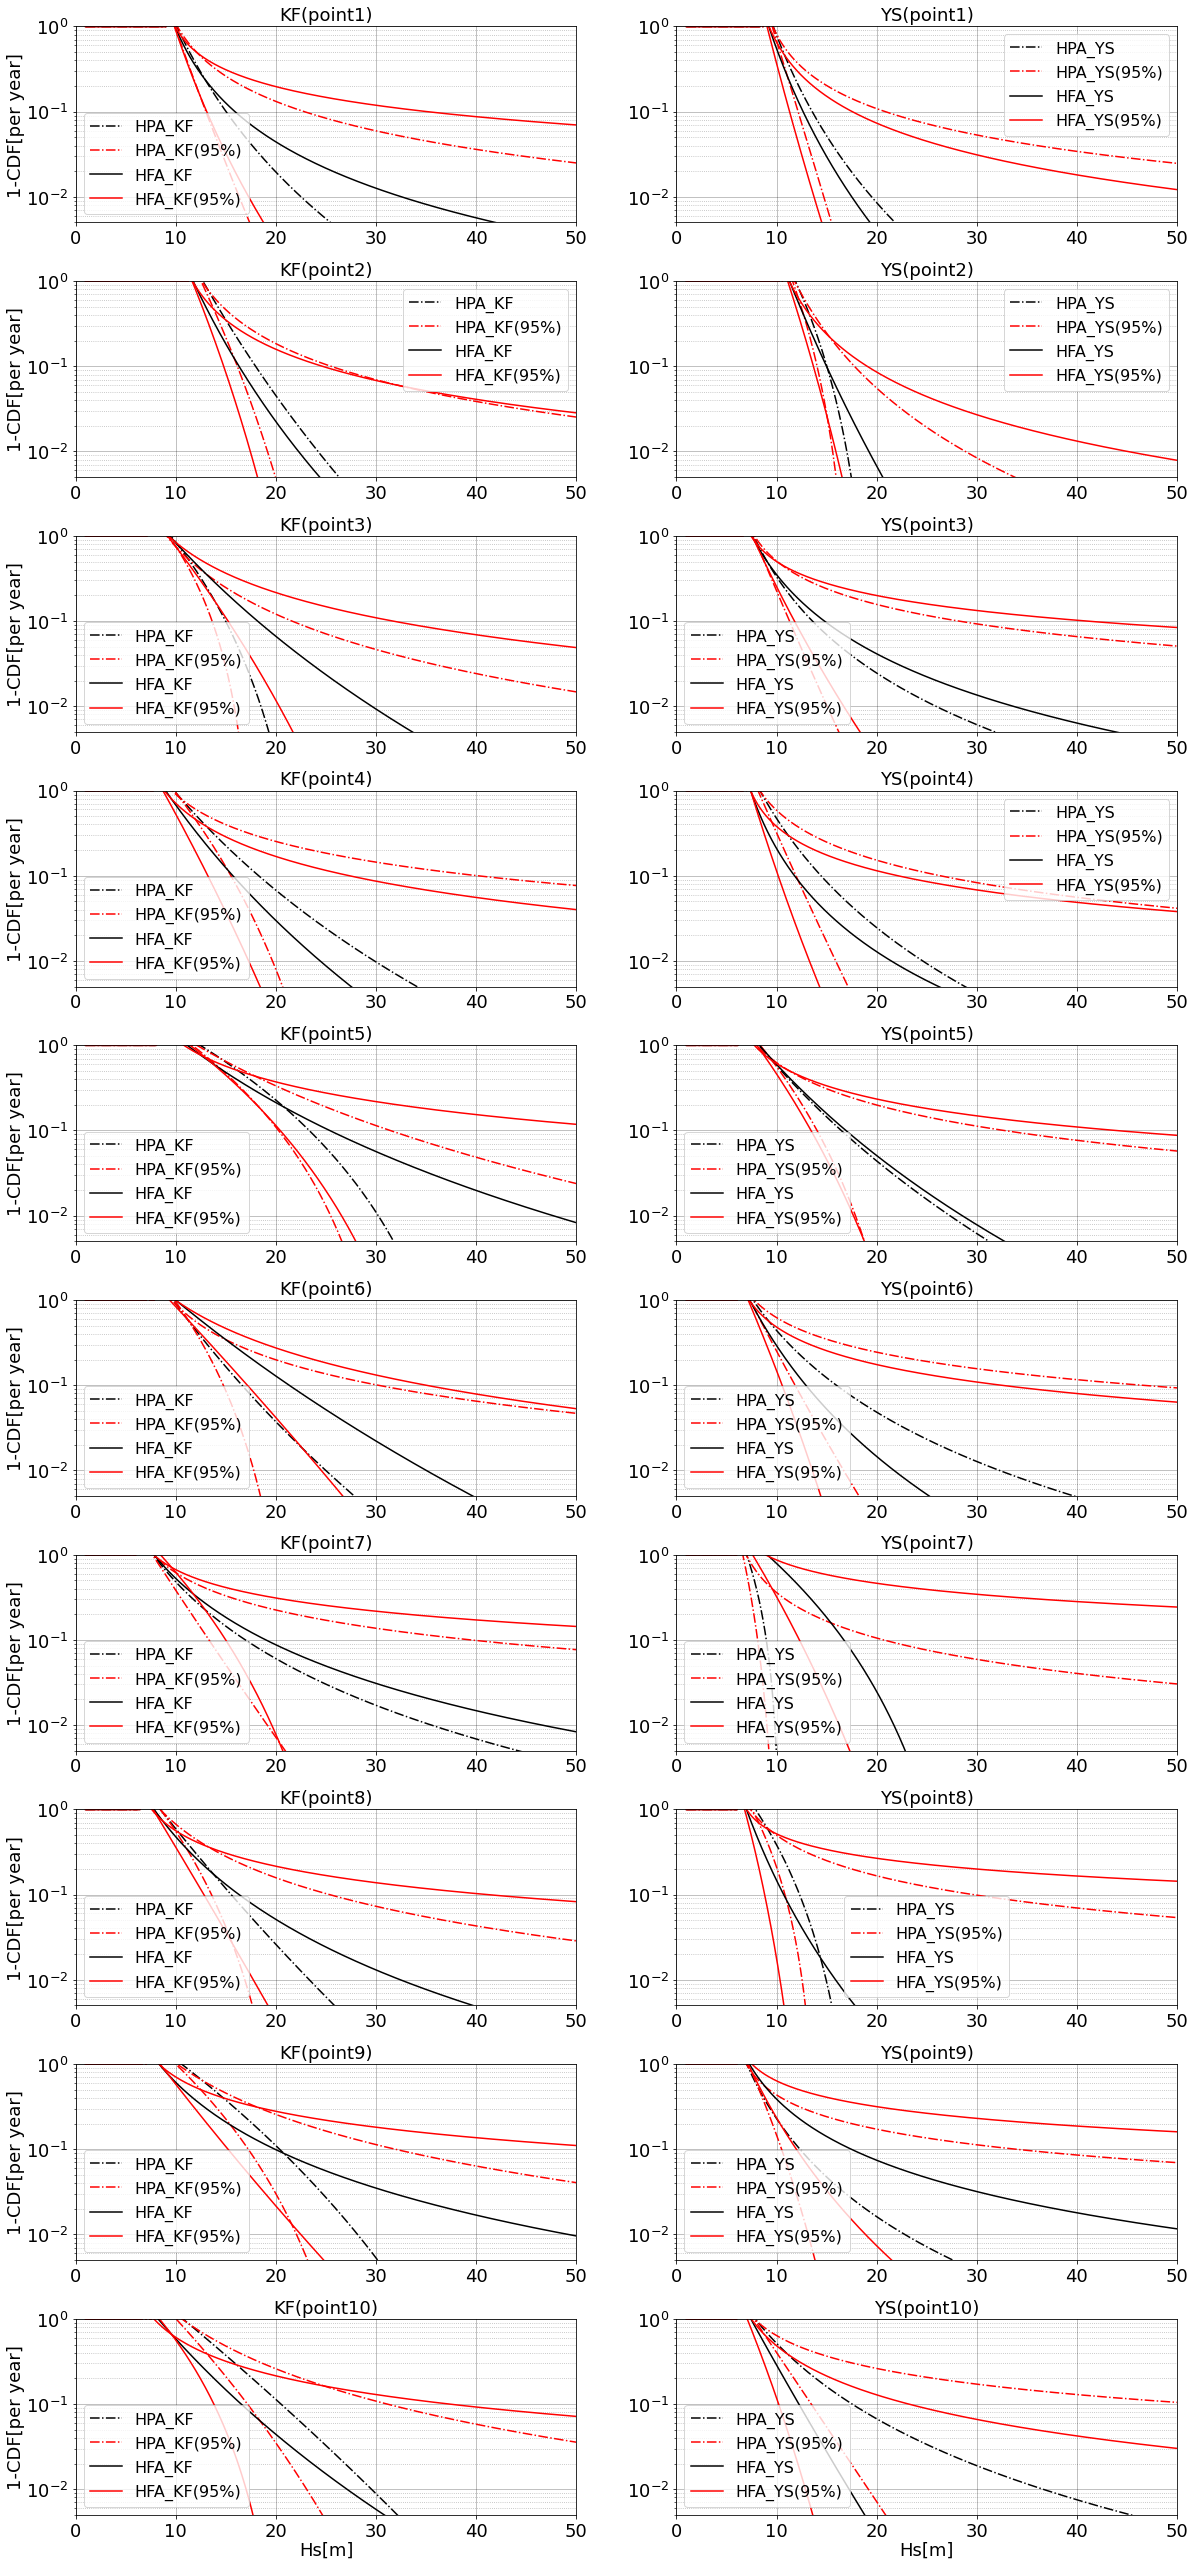

In [1]:
"""
LWMの出力結果を用いて, 極値増大確率の算出とCDFの描画をする.
"""

import func
from csv import reader
import matplotlib.pyplot as plt
import numpy as np

MODEL = ['KF', 'YS']
INDEX = sorted([79*67 + 13, 79*64 + 26, 79*43 + 23, 79*63 + 43, 79*51 + 39, 79*42 + 60, 79*60 + 56, 79*34 + 40, 79*20 + 70, 79*20 + 55])
def calc_p(past_rv, past_pro, f_rv, f_pro):
    """
    確率密度関数から, 極値増大確率を算出する
    """
    P = 0
    for i in range(len(past_rv)):
        p = 0
        for j in range(len(f_rv)):
            if f_rv[j] > past_rv[i]:
                p += f_pro[j]
        P += past_pro[i] * p
    return P * 100

def GP(xi, sgm, y, n0, n):
    """
    GPの1-CDF
    n0:閾値データ数
    n:全データ数
    """
    if y <= 0:
        return 1
    else:
        return (max(0, (1 + xi * y / sgm)) ** (-1/xi)) * n0 * 24 * 365 / n


DATA_CNT = 50

# 描画用の画像を用意
fig = plt.figure(figsize=(18, 36))
for index in range(len(INDEX)):
    idx = INDEX[index]
    print("----------", 'point' + str(index+1), idx, "----------")
    for i in range(2):  # model
        is_ok = True  # データ数がDATA_CNT以上あるかどうかのFlag(なければその地点は使用しない)
        for j in range(2):
            model = MODEL[i]
            # CSV名を指定するためにmodel名を変更
            if j == 0:  # 過去
                model = 'HPA_' + model
            else:  # 未来
                model = 'HFA_' + model + '_c0'
            with open('../pot_csv(100)(thr=6)/' + model + '_POT_DATA.csv', 'r') as csv_file:
                csv_reader = reader(csv_file)
                POT_ALL = list(csv_reader)
            POT = POT_ALL[idx] # 指定した場所のPOTを抽出
            # POTは文字列のリストになっているので, float型に変換する
            s = []
            for k in range(len(POT)):
                s.append(float(POT[k]))
            s = sorted(s, reverse=True)
            if len(POT) < 10:
                is_ok = False
                print("データ数：", len(POT), "データ数が不足しているため, この地点は使用できません")
            else:
                POT = s[:DATA_CNT]
                u = POT[-1]
                
                if j == 0:  # 過去
                    past_rv, past_pro, p_xi, p_sgm= func.lwm_gpd(data=POT, error=[0.005], thr=u, n=219143, n0=DATA_CNT, con=0.95)
                    u_p = u
                else:  # 将来
                    f_rv, f_pro, f_xi, f_sgm= func.lwm_gpd(data=POT, error=[0.005], thr=u, n=219143, n0=DATA_CNT, con=0.95)
                    u_f= u
        if is_ok:
            P = calc_p(past_rv, past_pro, f_rv, f_pro)
            print('{:.1f}'.format(P), '%の確率で極値増加')
            ax = fig.add_subplot(len(INDEX), 2, 2 * index + i+1)
            # MLのplot
            x = np.linspace(1, 50, 1000)
            ax.plot(x, [GP(xi=p_xi[1], sgm=p_sgm[1], y=x_ - u_p, n0=DATA_CNT, n=219143) for x_ in x], color='black', linestyle="dashdot", label='HPA_' + model[4:6])
            ax.plot(x, [GP(xi=p_xi[0], sgm=p_sgm[0], y=x_ - u_p, n0=DATA_CNT, n=219143) for x_ in x], color='red', linestyle="dashdot", label='HPA_' + model[4:6] + '(95%)')
            ax.plot(x, [GP(xi=p_xi[2], sgm=p_sgm[2], y=x_ - u_p, n0=DATA_CNT, n=219143) for x_ in x], color='red', linestyle="dashdot")
            ax.plot(x, [GP(xi=f_xi[1], sgm=f_sgm[1], y=x_ - u_f, n0=DATA_CNT, n=219143) for x_ in x], color='black', label=model[:-3])
            ax.plot(x, [GP(xi=f_xi[0], sgm=f_sgm[0], y=x_ - u_f, n0=DATA_CNT, n=219143) for x_ in x], color='red', label=model[:-3] + '(95%)')
            ax.plot(x, [GP(xi=f_xi[2], sgm=f_sgm[2], y=x_ - u_f, n0=DATA_CNT, n=219143) for x_ in x], color='red')
            ax.legend(fontsize=16)
            ax.set_xlim((0, 50))
            ax.set_ylim((0.005, 1))
            if index == len(INDEX) - 1:
                ax.set_xlabel("Hs[m]", fontsize=18, labelpad=1)
            if i == 0:
                ax.set_ylabel("1-CDF[per year]", fontsize=18, labelpad=1)
            ax.tick_params(axis='x', labelsize=18)
            ax.tick_params(axis='y', labelsize=18)
            ax.set_title(MODEL[i] + '(point' + str(index+1) + ')', fontsize=18)
            ax.set_yscale('log')
            ax.grid(which='major',color='black',linestyle='-', alpha=0.3)
            ax.grid(which='minor',color='black',linestyle='dotted', alpha=0.3)

# plt.subplots_adjust(hspace=0.3)
fig.subplots_adjust(left=0.1, right=0.95, bottom=0.02, top=0.98, hspace=0.3) #この1行を入れる
plt.savefig("../img/1-cdf_for_sum.png")
plt.show()